In [50]:
import scipy
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from yellowbrick.model_selection import FeatureImportances
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)
warnings.filterwarnings(action = 'ignore', category = FutureWarning)

The Kaggle dataset that I'm using: https://www.kaggle.com/datasets/iamsouravbanerjee/house-rent-prediction-dataset?resource=download

In [11]:
housing = pd.read_csv('House_Rent_Dataset.csv')
grid_dict = {}
acc_dict = {}
housing

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2,15000,1000,3 out of 5,Carpet Area,Bandam Kommu,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
4744,2022-07-06,3,45000,1500,23 out of 34,Carpet Area,Gachibowli,Hyderabad,Semi-Furnished,Family,2,Contact Agent


See how the DataFrame that was created looks like

In [12]:
housing.describe()

,BHK,Rent,Size,Bathroom
count,4746.000000,4.746000e+03,4746.000000,4746.000000
mean,2.083860,3.499345e+04,967.490729,1.965866
std,0.832256,7.810641e+04,634.202328,0.884532
min,1.000000,1.200000e+03,10.000000,1.000000
25%,2.000000,1.000000e+04,550.000000,1.000000
50%,2.000000,1.600000e+04,850.000000,2.000000
75%,3.000000,3.300000e+04,1200.000000,2.000000
max,6.000000,3.500000e+06,8000.000000,10.000000


Floor the size and rent values to reduce clutter on graphs

In [13]:
housing['Rent_new'] = (housing['Rent'] / 100).apply(np.floor).astype(int) * 100
housing['Size_new'] = (housing['Size'] / 100).apply(np.floor).astype(int) * 100

See how the distribution of the size of the house is and the distribution of the rent is.

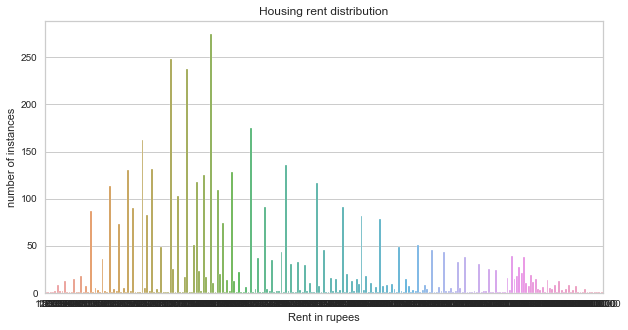

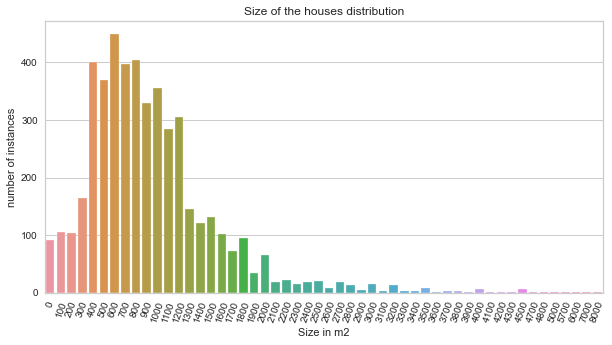

In [15]:
temp = housing["Rent_new"].value_counts()
df = pd.DataFrame({'Rent in rupees': temp.index,
                   'number of instances': temp.values
                  })
plt.figure(figsize=(10,5))
plt.title("Housing rent distribution")
sns.barplot(x = 'Rent in rupees', y="number of instances", data=df)
plt.show()

temp = housing["Size_new"].value_counts()
df = pd.DataFrame({'Size in m2': temp.index,
                   'number of instances': temp.values
                  })
plt.figure(figsize=(10,5))
plt.title("Size of the houses distribution")
sns.barplot(x = 'Size in m2', y="number of instances", data=df)
plt.xticks(rotation=70)
plt.show()


By looking at the distribution graphs it looks like that size does somewhat influence the rent price but there seem to be other factors that also influence the rent price

Setting the rent as the target

In [42]:
# Assigning X to data and y to target
y_housing = housing['Rent']
X_housing = housing[['Size', 'BHK', 'Bathroom']]
reg_housing = housing[['Rent', 'Size', 'BHK', 'Bathroom']]

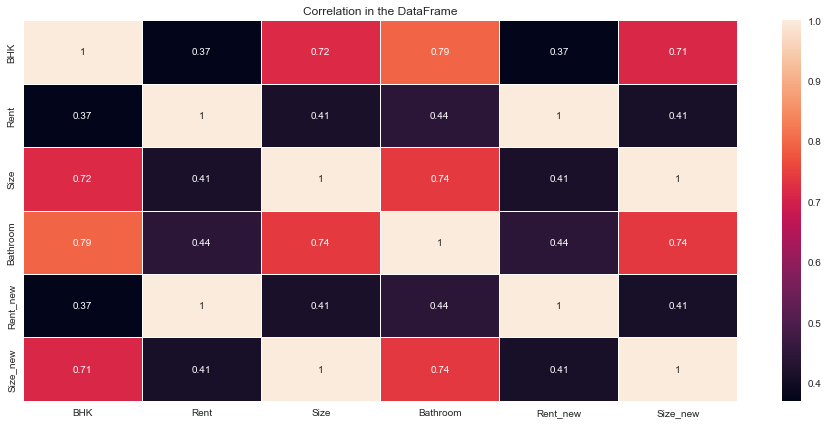

In [23]:
plt.figure(figsize=(16, 7))

# Finding the correlation between the columns in the dataset
plt.title('Correlation in the DataFrame')
sns.heatmap(housing.corr(), annot=True, fmt='0.2g', linewidths=1)
plt.show()

There seems to be a high correlation between the size of the house and the size of the bathroom which makes sense as a larger house has more space for a larger bathroom.
The correlation between Size and Rent shows that there is somewhat of a correlation between the two just as the distribution graphs showed

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_housing, y_housing, test_size=0.25, random_state=42)


Use one classifier to test feature importance and see what accuracy it produces

In [25]:
# DecisionTree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
# Accuracy for pre GridSearchCV classifier
dt_acc1 = accuracy_score(y_test, dt.predict(X_test))
# Parameters for GridSearchCV
param_grid = {'criterion': ['gini', 'entropy'],
			  'splitter': ['best', 'random'],
			  'max_depth': [4, 5, 7, 9, 10, 11, None, 100, 25, 50]}

grid = GridSearchCV(dt, param_grid, refit=True, verbose=3, n_jobs=-1, cv=10)
grid.fit(X_train, y_train)
grid_predictions = grid.predict(X_test)
dt2 = DecisionTreeClassifier(criterion=grid.best_estimator_.criterion, splitter=grid.best_estimator_.splitter,
							 max_depth=grid.best_estimator_.max_depth)
dt2.fit(X_train, y_train)
# Accuracy for post GridSearchCV classifier
dt_acc2 = accuracy_score(y_test, dt2.predict(X_test))
grid_dict["dtc_acc_red"] = grid.best_params_
# Inserting both accuracy scores for comparison
acc_dict["DT_red"] = [dt_acc1, dt_acc2]

Fitting 10 folds for each of 40 candidates, totalling 400 fits


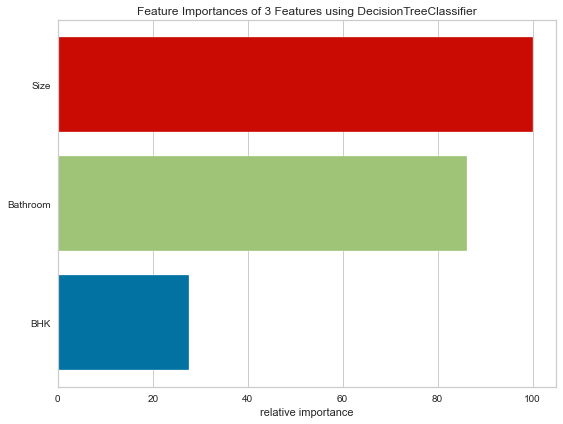

<Figure size 432x288 with 0 Axes>

In [26]:
fig = plt.figure(figsize=(15,6))

ax2 = plt.subplot(122)
viz2 = FeatureImportances(dt2)
viz2.fit(X_housing, y_housing)
viz2.show()

plt.tight_layout()


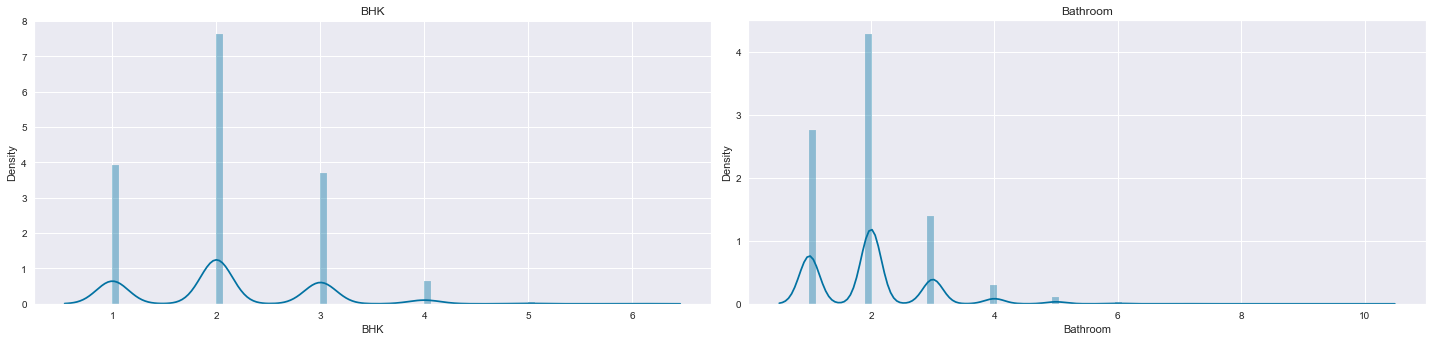

In [27]:
cols = X_housing.columns

fig = plt.figure(figsize=(20,90))



for i in range(1, len(cols)):
    ax = fig.add_subplot(20, 2, i)
    g = sns.distplot(X_housing[cols[i]], bins=80)
    plt.title(cols[i])
fig.tight_layout()

In [37]:
from sklearn.cluster import KMeans
skplt.cluster.plot_elbow_curve(KMeans(random_state=1),
                               X_housing,
                               cluster_ranges=range(2, 20),
                               figsize=(8,6));

ValueError: could not convert string to float: '2022-05-18'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


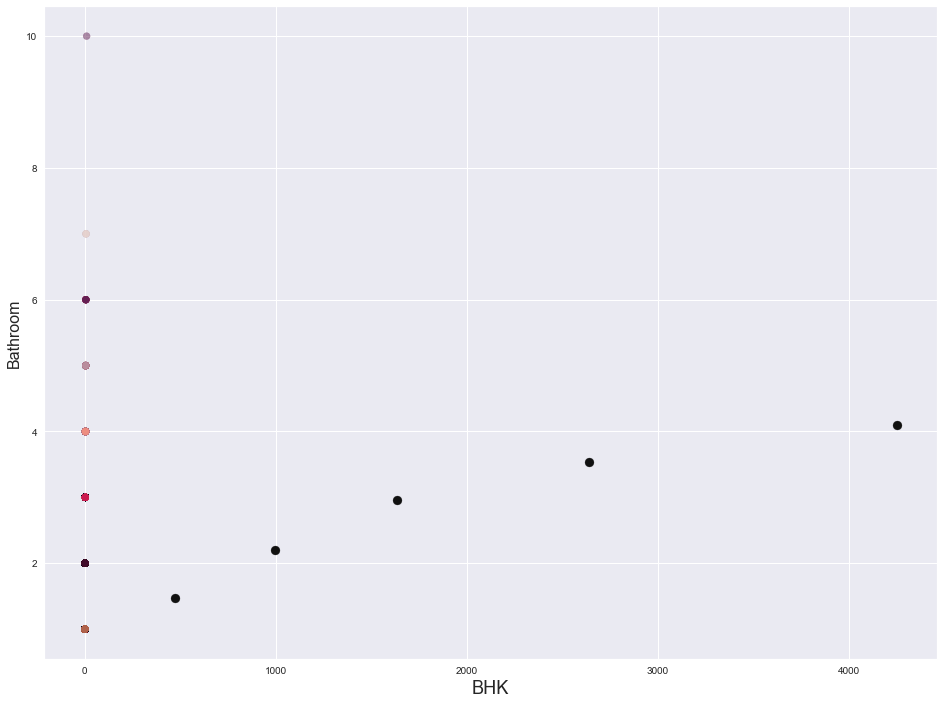

In [43]:
#Getting unique labels
X = reg_housing.values[:, 1:]
Clus_dataset = StandardScaler().fit_transform(X)

#Initialize the class object
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
labels = kmeans.labels_

X_housing['Clus_km'] = labels

centroids = kmeans.cluster_centers_
u_labels = np.unique(labels)

#plotting the results:
col = ['green', 'purple', 'red', 'yellow', 'blue', 'white']
#create 2 dimensional graph
f3, ax = plt.subplots(figsize=(16, 12))
plt.scatter(X[:, 2], X[:, 2], c=labels.astype(np.float), alpha=.5)
plt.xlabel('BHK', fontsize=18)
plt.ylabel('Bathroom', fontsize=16)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

No valuable information can be gleaned with KMeans as there are too few integer or float variables to use from the dataset. Thus a wordbag could be useful

In [44]:
linear = LinearRegression()
linear.fit(X_train, y_train)
linear.score(X_test, y_test)

0.36401971195197935

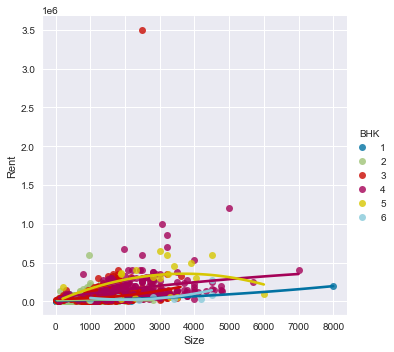

In [48]:

sns.lmplot(x='Size', y='Rent', data=reg_housing, hue='BHK', order=2, ci=False)

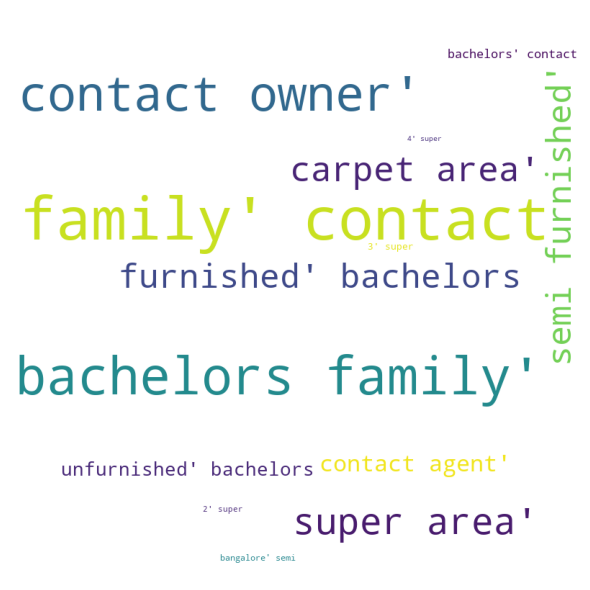

In [51]:
comment_words = ''
for val in housing.values:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                relative_scaling = 1,
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()